In [1]:
#引用相關函式

import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

import keras
import keras.backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.layers import Input, Dense, Dropout, CuDNNGRU, Embedding

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# 引用Session-based Recommendations with Recurrent Neural Networks
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""    
    def __init__(self, data, sep='\t', session_key='SessionId', item_key='ItemId', time_key='Time', n_samples=-1, itemmap=None, time_sort=False):
        """
        Args:
            path: path of the csv file
            sep: separator for the csv
            session_key, item_key, time_key: name of the fields corresponding to the sessions, items, time
            n_samples: the number of samples to use. If -1, use the whole dataset.
            itemmap: mapping between item IDs and item indices
            time_sort: whether to sort the sessions by time or not
        """
        self.df = data
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.time_sort = time_sort
        self.add_item_indices(itemmap=itemmap)
        self.df.sort_values([session_key, time_key], inplace=True)

        # Sort the df by time, and then by session ID. That is, df is sorted by session ID and
        # clicks within a session are next to each other, where the clicks within a session are time-ordered.

        self.click_offsets = self.get_click_offsets()
        self.session_idx_arr = self.order_session_idx()
        
    def get_click_offsets(self):
        """
        Return the offsets of the beginning clicks of each session IDs,
        where the offset is calculated against the first click of the first session ID.
        """
        offsets = np.zeros(self.df[self.session_key].nunique() + 1, dtype=np.int32)
        # group & sort the df by session_key and get the offset values
        offsets[1:] = self.df.groupby(self.session_key).size().cumsum()

        return offsets

    def order_session_idx(self):
        """ Order the session indices """
        if self.time_sort:
            # starting time for each sessions, sorted by session IDs
            sessions_start_time = self.df.groupby(self.session_key)[self.time_key].min().values
            # order the session indices by session starting times
            session_idx_arr = np.argsort(sessions_start_time)
        else:
            session_idx_arr = np.arange(self.df[self.session_key].nunique())

        return session_idx_arr
    
    def add_item_indices(self, itemmap=None):
        """ 
        Add item index column named "item_idx" to the df
        Args:
            itemmap (pd.DataFrame): mapping between the item Ids and indices
        """
        if itemmap is None:
            item_ids = self.df[self.item_key].unique()  # unique item ids
            item2idx = pd.Series(data=np.arange(len(item_ids)),
                                 index=item_ids)
            itemmap = pd.DataFrame({self.item_key:item_ids,
                                   'item_idx':item2idx[item_ids].values})
        
        self.itemmap = itemmap
        self.df = pd.merge(self.df, self.itemmap, on=self.item_key, how='inner')
        
    @property    
    def items(self):
        return self.itemmap.ItemId.unique()
        

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""    
    def __init__(self, dataset, batch_size=50):
        """
        A class for creating session-parallel mini-batches.
        Args:
            dataset (SessionDataset): the session dataset to generate the batches from
            batch_size (int): size of the batch
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.done_sessions_counter = 0
        
    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        df = self.dataset.df
        session_key='SessionId'
        item_key='ItemId'
        time_key='TimeStamp'
        self.n_items = df[item_key].nunique()+1
        click_offsets = self.dataset.click_offsets
        session_idx_arr = self.dataset.session_idx_arr

        iters = np.arange(self.batch_size)
        maxiter = iters.max()
        start = click_offsets[session_idx_arr[iters]]
        end = click_offsets[session_idx_arr[iters] + 1]
        mask = [] # indicator for the sessions to be terminated
        finished = False        

        while not finished:
            minlen = (end - start).min()
            # Item indices (for embedding) for clicks where the first sessions start
            idx_target = df.item_idx.values[start]
            for i in range(minlen - 1):
                # Build inputs & targets
                idx_input = idx_target
                idx_target = df.item_idx.values[start + i + 1]
                inp = idx_input
                target = idx_target
                yield inp, target, mask
                
            # click indices where a particular session meets second-to-last element
            start = start + (minlen - 1)
            # see if how many sessions should terminate
            mask = np.arange(len(iters))[(end - start) <= 1]
            self.done_sessions_counter = len(mask)
            for idx in mask:
                maxiter += 1
                if maxiter >= len(click_offsets) - 1:
                    finished = True
                    break
                # update the next starting/ending point
                iters[idx] = maxiter
                start[idx] = click_offsets[session_idx_arr[maxiter]]
                end[idx] = click_offsets[session_idx_arr[maxiter] + 1]


def create_model(args):   
    emb_size = 200
    hidden_units = 200
    size = emb_size

    inputs = Input(batch_shape=(args.batch_size, 1, args.train_n_items))
    gru, gru_states = CuDNNGRU(hidden_units, stateful=True, return_state=True)(inputs)
    drop2 = Dropout(0.25)(gru)
    predictions = Dense(args.train_n_items, activation='softmax')(drop2)
    model = Model(inputs=inputs, outputs=[predictions])
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss=categorical_crossentropy, optimizer=opt)
    model.summary()

    filepath='model_checkpoint.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=2, save_best_only=True, mode='min')
    callbacks_list = []
    return model


def get_states(model):
    return [K.get_value(s) for s,_ in model.state_updates]


def get_metrics(model, args, train_generator_map, recall_k=10, mrr_k=10):

    test_dataset = SessionDataset(args.test_data, itemmap=train_generator_map)
    test_generator = SessionDataLoader(test_dataset, batch_size=args.batch_size)

    n = 0
    rec_sum = 0
    mrr_sum = 0

    with tqdm(total=args.test_samples_qty) as pbar:
        for feat, label, mask in test_generator:

            target_oh = to_categorical(label, num_classes=args.train_n_items)
            input_oh  = to_categorical(feat,  num_classes=args.train_n_items) 
            input_oh = np.expand_dims(input_oh, axis=1)
            
            pred = model.predict(input_oh, batch_size=args.batch_size)

            for row_idx in range(feat.shape[0]):
                pred_row = pred[row_idx] 
                label_row = target_oh[row_idx]

                rec_idx =  pred_row.argsort()[-recall_k:][::-1]
                mrr_idx =  pred_row.argsort()[-mrr_k:][::-1]
                tru_idx = label_row.argsort()[-1:][::-1]

                n += 1

                if tru_idx[0] in rec_idx:
                    rec_sum += 1

                if tru_idx[0] in mrr_idx:
                    mrr_sum += 1/int((np.where(mrr_idx == tru_idx[0])[0]+1))
            
            pbar.set_description("Evaluating model")
            pbar.update(test_generator.done_sessions_counter)

    recall = rec_sum/n
    mrr = mrr_sum/n
    return (recall, recall_k), (mrr, mrr_k)


def train_model(model, args, save_weights = False):
    train_dataset = SessionDataset(args.train_data)
    model_to_train = model
    batch_size = args.batch_size
    
    num_round = 30
    x = [i for i in range(0,num_round)]
    y_recall = []
    y_mrr = []
    
    for epoch in range(0, num_round):
        with tqdm(total=args.train_samples_qty) as pbar:
            loader = SessionDataLoader(train_dataset, batch_size=batch_size)
            for feat, target, mask in loader:
                
                real_mask = np.ones((batch_size, 1))
                for elt in mask:
                    real_mask[elt, :] = 0

                hidden_states = get_states(model_to_train)[0]
                hidden_states = np.multiply(real_mask, hidden_states)
                hidden_states = np.array(hidden_states, dtype=np.float32)
                model_to_train.layers[1].reset_states(hidden_states)

                input_oh = to_categorical(feat, num_classes=loader.n_items) 
                input_oh = np.expand_dims(input_oh, axis=1)

                target_oh = to_categorical(target, num_classes=loader.n_items)

                tr_loss = model_to_train.train_on_batch(input_oh, target_oh)

                pbar.set_description("Epoch {0}. Loss: {1:.5f}".format(epoch, tr_loss))
                pbar.update(loader.done_sessions_counter)
            
        
        if save_weights:
            print("Saving weights...")
            model_to_train.save('GRU4REC_{}.h5'.format(epoch))
        
        
        
        (rec, rec_k), (mrr, mrr_k) = get_metrics(model_to_train, args, train_dataset.itemmap)
        y_recall.append(rec)
        y_mrr.append(mrr)

        print("\t - Recall@{} epoch {}: {:5f}".format(rec_k, epoch, rec))
        print("\t - MRR@{}    epoch {}: {:5f}".format(mrr_k, epoch, mrr))
        print("\n")
        
    plt.figure(figsize=(8,4))
    plt.plot(x,y_recall,label="recall@{}".format(rec_k))
    plt.plot(x,y_mrr,label="mrr@{}".format(mrr_k))
    plt.xlabel("epoch")
    plt.show()
        
        


訓練影片數目: 11618
訓練使用者數目: 19855
測試使用者數目: 5272
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (512, 1, 11618)           0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       [(512, 200), (512, 200)]  7092000   
_________________________________________________________________
dropout_1 (Dropout)          (512, 200)                0         
_________________________________________________________________
dense_1 (Dense)              (512, 11618)              2335218   
Total params: 9,427,218
Trainable params: 9,427,218
Non-trainable params: 0
_________________________________________________________________


  0%|          | 0/19855 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


Epoch 0. Loss: 7.26748:  97%|█████████▋| 19329/19855 [01:49<00:02, 176.46it/s]


Saving weights...


Epoch 1. Loss: 7.26369:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 0: 0.053619
	 - MRR@10    epoch 0: 0.015498




Epoch 1. Loss: 6.86162:  97%|█████████▋| 19329/19855 [01:16<00:02, 251.35it/s]


Saving weights...


Epoch 2. Loss: 6.60770:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 1: 0.063600
	 - MRR@10    epoch 1: 0.023697




Epoch 2. Loss: 6.54962:  97%|█████████▋| 19329/19855 [01:30<00:02, 214.54it/s]


Saving weights...


Epoch 3. Loss: 6.29981:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 2: 0.069718
	 - MRR@10    epoch 2: 0.027042




Epoch 3. Loss: 6.35394:  97%|█████████▋| 19329/19855 [01:38<00:02, 195.85it/s]


Saving weights...


Epoch 4. Loss: 6.10958:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 3: 0.076317
	 - MRR@10    epoch 3: 0.030319




Epoch 4. Loss: 6.22183:  97%|█████████▋| 19329/19855 [01:27<00:02, 221.41it/s]


Saving weights...


Epoch 5. Loss: 5.98214:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 4: 0.080862
	 - MRR@10    epoch 4: 0.032497




Epoch 5. Loss: 6.13556:  97%|█████████▋| 19329/19855 [01:21<00:02, 235.73it/s]


Saving weights...


  0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 5: 0.083106
	 - MRR@10    epoch 5: 0.033657




Epoch 6. Loss: 6.01044:  97%|█████████▋| 19329/19855 [01:46<00:02, 181.98it/s]


Saving weights...


Epoch 7. Loss: 6.02866:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 6: 0.085324
	 - MRR@10    epoch 6: 0.034186




Epoch 7. Loss: 5.93316:  97%|█████████▋| 19329/19855 [00:53<00:01, 362.53it/s]


Saving weights...


Epoch 8. Loss: 6.42929:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 7: 0.086291
	 - MRR@10    epoch 7: 0.034624




Epoch 8. Loss: 5.87774:  97%|█████████▋| 19329/19855 [01:52<00:03, 172.23it/s]


Saving weights...


Epoch 9. Loss: 5.99492:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 8: 0.086456
	 - MRR@10    epoch 8: 0.034797




Epoch 9. Loss: 5.84081:  97%|█████████▋| 19329/19855 [01:08<00:01, 281.80it/s]


Saving weights...


Epoch 10. Loss: 6.38722:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 9: 0.085558
	 - MRR@10    epoch 9: 0.034352




Epoch 10. Loss: 5.73480:  97%|█████████▋| 19329/19855 [02:00<00:03, 160.59it/s]


Saving weights...


Epoch 11. Loss: 5.91063:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 10: 0.086279
	 - MRR@10    epoch 10: 0.034505




Epoch 11. Loss: 5.70870:  97%|█████████▋| 19329/19855 [01:14<00:02, 259.06it/s]


Saving weights...


Epoch 12. Loss: 5.82322:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 11: 0.086772
	 - MRR@10    epoch 11: 0.034812




Epoch 12. Loss: 5.66195:  97%|█████████▋| 19329/19855 [02:04<00:03, 155.51it/s]


Saving weights...


Epoch 13. Loss: 5.88979:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 12: 0.086437
	 - MRR@10    epoch 12: 0.034881




Epoch 13. Loss: 5.63008:  97%|█████████▋| 19329/19855 [01:00<00:01, 318.63it/s]


Saving weights...


Epoch 14. Loss: 5.59497:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 13: 0.086127
	 - MRR@10    epoch 13: 0.034874




Epoch 14. Loss: 5.58816:  97%|█████████▋| 19329/19855 [01:32<00:02, 207.96it/s]


Saving weights...


Epoch 15. Loss: 5.63800:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 14: 0.086380
	 - MRR@10    epoch 14: 0.034803




Epoch 15. Loss: 5.49780:  97%|█████████▋| 19329/19855 [01:24<00:02, 229.95it/s]


Saving weights...


Epoch 16. Loss: 5.88333:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 15: 0.085912
	 - MRR@10    epoch 15: 0.034654




Epoch 16. Loss: 5.45564:  97%|█████████▋| 19329/19855 [01:13<00:01, 263.84it/s]


Saving weights...


Epoch 17. Loss: 6.27481:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 16: 0.086254
	 - MRR@10    epoch 16: 0.034857




Epoch 17. Loss: 5.39052:  97%|█████████▋| 19329/19855 [01:44<00:02, 184.96it/s]


Saving weights...


Epoch 18. Loss: 5.52122:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 17: 0.085938
	 - MRR@10    epoch 17: 0.034801




Epoch 18. Loss: 5.40780:  97%|█████████▋| 19329/19855 [01:00<00:01, 322.05it/s]


Saving weights...


Epoch 19. Loss: 5.77870:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 18: 0.086418
	 - MRR@10    epoch 18: 0.034491




Epoch 19. Loss: 5.41208:  97%|█████████▋| 19329/19855 [01:31<00:02, 210.89it/s]


Saving weights...


Epoch 20. Loss: 5.51640:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 19: 0.085887
	 - MRR@10    epoch 19: 0.034652




Epoch 20. Loss: 5.40546:  97%|█████████▋| 19329/19855 [01:14<00:02, 258.19it/s]


Saving weights...


Epoch 21. Loss: 5.50583:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 20: 0.086108
	 - MRR@10    epoch 20: 0.034605




Epoch 21. Loss: 5.34358:  97%|█████████▋| 19329/19855 [01:19<00:02, 241.82it/s]


Saving weights...


Epoch 22. Loss: 5.45524:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 21: 0.086405
	 - MRR@10    epoch 21: 0.034659




Epoch 22. Loss: 5.31190:  97%|█████████▋| 19329/19855 [01:39<00:02, 195.11it/s]


Saving weights...


Epoch 23. Loss: 5.46145:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 22: 0.085773
	 - MRR@10    epoch 22: 0.034652




Epoch 23. Loss: 5.27795:  97%|█████████▋| 19329/19855 [01:10<00:01, 275.31it/s]


Saving weights...


Epoch 24. Loss: 6.29158:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 23: 0.086317
	 - MRR@10    epoch 23: 0.034644




Epoch 24. Loss: 5.28213:  97%|█████████▋| 19329/19855 [01:49<00:02, 176.07it/s]


Saving weights...


Epoch 25. Loss: 5.45640:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 24: 0.085773
	 - MRR@10    epoch 24: 0.034525




Epoch 25. Loss: 5.32470:  97%|█████████▋| 19329/19855 [01:02<00:01, 310.66it/s]


Saving weights...


Epoch 26. Loss: 5.72598:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 25: 0.086013
	 - MRR@10    epoch 25: 0.034599




Epoch 26. Loss: 5.30686:  97%|█████████▋| 19329/19855 [01:36<00:02, 199.29it/s]


Saving weights...


Epoch 27. Loss: 5.44932:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 26: 0.085956
	 - MRR@10    epoch 26: 0.034530




Epoch 27. Loss: 5.19546:  97%|█████████▋| 19329/19855 [00:56<00:01, 341.82it/s]


Saving weights...


Epoch 28. Loss: 5.67445:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 27: 0.085369
	 - MRR@10    epoch 27: 0.034441




Epoch 28. Loss: 5.22937:  97%|█████████▋| 19329/19855 [01:32<00:02, 209.52it/s]


Saving weights...


Epoch 29. Loss: 5.48513:   0%|          | 0/19855 [00:00<?, ?it/s]

	 - Recall@10 epoch 28: 0.085407
	 - MRR@10    epoch 28: 0.034247




Epoch 29. Loss: 5.20246:  97%|█████████▋| 19329/19855 [01:23<00:02, 232.73it/s]


Saving weights...


Evaluating model:  82%|████████▏ | 4327/5272 [04:09<00:54, 17.33it/s]


	 - Recall@10 epoch 29: 0.085761
	 - MRR@10    epoch 29: 0.034030




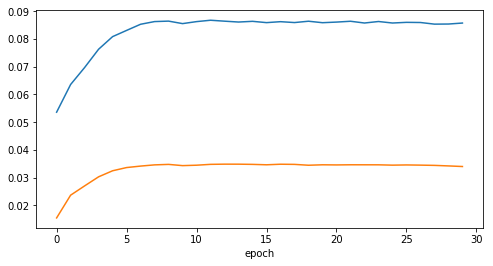

In [3]:
# 建立DataSet物件
class DataSet():
    def __init__(self):
        pass

dataSet = DataSet()

# 寫入物件所需參數 
# batch_size
dataSet.batch_size = 512
# 處理過的訓練資料
dataSet.train_data = pd.read_csv("data/augmented_train_basic.csv", sep='\t', dtype={'ItemId': np.int64})
# 開發資料
dataSet.dev_data   = pd.read_csv("data/dev.csv",   sep='\t', dtype={'ItemId': np.int64})
# 測試資料
dataSet.test_data  = pd.read_csv("data/test.csv",  sep='\t', dtype={'ItemId': np.int64})
# 影片數目
dataSet.train_n_items = len(dataSet.train_data['ItemId'].unique()) + 1
print("訓練影片數目:", dataSet.train_n_items)
# 使用者數目
dataSet.train_samples_qty = len(dataSet.train_data['SessionId'].unique()) + 1
print("訓練使用者數目:", dataSet.train_samples_qty)
dataSet.test_samples_qty = len(dataSet.test_data['SessionId'].unique()) + 1
print("測試使用者數目:", dataSet.test_samples_qty)

# 建立模型
model = create_model(dataSet)

# 訓練模型
train_model(model, dataSet, save_weights=True)